# Testing EOF decomposition with dask using `xeofs` package

In progress work using the `xeofs` package to analyze multi-decadal SST variability on a local machine. Data are accessed using `earthaccess` package.

Ultimately want to perform an analysis such as: https://doi.org/10.1175/2011JCLI3941.1 

Which uses the dataset: https://podaac.jpl.nasa.gov/dataset/REYNOLDS_NCDC_L4_MONTHLY_V5

Thise notebook is meant to be run as a Coiled Notebook, see docs here: https://docs.coiled.io/user_guide/usage/notebooks/index.html#notebook-file-sync 

Additional reference used for EOF analysis: https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex18-EOF%20analysis%20global%20SST.ipynb

Because the time variable in this dataset is non-conventional, the `cftime` package is required to decode the timestamps using `Xarray`.

Although the above study uses the time period 1910 to 2009, we instead use 1910 to 2008, since the data providers of the dataset changed the time format from 2008 onward and xarray doesn't like it.

## 1. Access and load MUR data

Currently need an earthaccess patch to run the `xeofs` package wish dask:

In [1]:
!pip uninstall -y earthaccess

Found existing installation: earthaccess 0.5.3
Uninstalling earthaccess-0.5.3:
  Successfully uninstalled earthaccess-0.5.3


In [2]:
!pip install -U git+https://github.com/nsidc/earthaccess.git@main

  Cloning https://github.com/nsidc/earthaccess.git (to revision main) to /tmp/pip-req-build-l2gs4cou
  Running command git clone --filter=blob:none --quiet https://github.com/nsidc/earthaccess.git /tmp/pip-req-build-l2gs4cou
  Resolved https://github.com/nsidc/earthaccess.git to commit 18f05edad5bce5441ac914804c7189dd0b0d7dde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for earthaccess: filename=earthaccess-0.5.4-py3-none-any.whl size=54732 sha256=8f88cf84a612eab25572c359467bd2bf0b8b17454698e82f49a0819c7ec196ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-wdtscwc2/wheels/a3/fb/0b/7cf7835b92c87d8ff3605bebb3d1595bd670a84e4afc24a902
Successfully built earthaccess


In [1]:
import earthaccess
import xarray as xr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from cartopy.crs import EqualEarth, PlateCarree

%matplotlib inline

In [2]:
print(earthaccess.__version__)
print(earthaccess.__file__)

0.5.3
/home/ec2-user/miniconda3/envs/jupyter/lib/python3.11/site-packages/earthaccess/__init__.py


In [3]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using .netrc file for EDL


In [4]:
%%time

endpoints = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2007-12-31"),
    )

Granules found: 1177
CPU times: user 194 ms, sys: 8.69 ms, total: 203 ms
Wall time: 26.9 s


In [5]:
%%time

fileobjs = earthaccess.open(endpoints)

 Opening 1177 granules, approx size: 0.12 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1177 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1177 [00:00<?, ?it/s]

CPU times: user 2.55 s, sys: 247 ms, total: 2.8 s
Wall time: 50.9 s


**Found a weird result in one of the file objects:**

In [6]:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

[FileNotFoundError('s3://podaac-ops-cumulus-internal/file-staging/podaac-ops-cumulus/REYNOLDS_NCDC_L4_MONTHLY_V5___5/ersst.v5.195908.nc.1')]


**The above file does not show up in CMR: https://cmr.earthdata.nasa.gov/virtual-directory/collections/C2036878116-POCLOUD/temporal**

This is worth looking into, but for now just remove this object from the list and continue:

In [7]:
fileobjs_good = [f for f in fileobjs if type(f) != FileNotFoundError]

In [8]:
print(len(fileobjs))
print(len(fileobjs_good))

1177
1176


#### **Can runtime of the below line be decreased using parallelization?**

In [9]:
%%time

#sstdata = xr.open_mfdataset(fileobjs_good, chunks={})
sstdata = xr.open_mfdataset(fileobjs_good[:204], chunks={})

CPU times: user 9.03 s, sys: 208 ms, total: 9.23 s
Wall time: 2min 4s


In [12]:
sstdata = sstdata.squeeze()
sstdata

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 204)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1909-12-01 00:00:00 ... 1926-11-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.190912
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

## 1 Alt: Access files different method

In [254]:
# Alternate method to access files, temporary fix if working on JPL VPN and want S3 endpoints. Currently earthaccess 
# doesn't work with JPL VPN. Use s3fs package instead.

def init_S3FileSystem():
    """
    This routine automatically pulls your EDL crediential from .netrc file and uses it 
    to obtain a temporary AWS S3 credential through a podaac service accessable at 
    https://archive.podaac.earthdata.nasa.gov/s3credentials
    
    Return:
    =======
    s3: an AWS S3 filesystem
    """
    import requests, s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'],
                           client_kwargs={'region_name':'us-west-2'})
    return s3


# Get temporary AWS credentials for access
fs_s3 = init_S3FileSystem()


# Check that S3 connection was successful:
s3path = "s3://podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/"
endpoints = fs_s3.glob(s3path+"*.nc")
print("total files found = ",len(endpoints))
print("Example filename: ", endpoints[0])


# Get subset of files in the 1910 - 2007 time range:
#yyyymm = [int(f.split('.')[-2]) for f in fns]
endpoints = [f for f in endpoints if int(f.split('.')[-2]) > 190912]
endpoints = [f for f in endpoints if int(f.split('.')[-2]) < 200801]

total files found =  2034
Example filename:  podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.185401.nc


In [261]:
%%time

fileobjs = [fs_s3.open(f, mode='rb') for f in endpoints]
#sstdata = xr.open_mfdataset(fileobjs_good, chunks={})
sstdata = xr.open_mfdataset(fileobjs, chunks={})

CPU times: user 50 s, sys: 337 ms, total: 50.3 s
Wall time: 3min 9s


In [262]:
sstdata = sstdata.squeeze()
sstdata

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.191001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

## 2. Detrend and Remove Seasonal Cycle

In [357]:
tempholder = sstdata

In [358]:
# Remove data poleward of 65 degress lat:
sstdata = sstdata.sel(lat=slice(-65, 65))

### 2.1 Linear Detrend

Options:
* scipy.signal.detrend()
* ...

In [1]:
# xr.apply_ufunc(
#     np.nanmean, sst, 
#     input_core_dims=[['lat','lon']], 
#     #output_core_dims=[['lat']],
#     kwargs={"axis": (1,2)},
#     dask='allowed').compute()

In [12]:
# from scipy.stats import linregress

**For each lat, lon gridpoint, the data across all timestamps are either (1) all nan's or (2) no nan's. The following code verifies this:**

In [359]:
nt, nlat, nlon = sstdata['sst'].shape

In [360]:
n_null = sstdata['sst'].isnull().sum(axis=0).compute().values.flatten()

In [361]:
n_nonan = (n_null == 0).sum() # Either no NANs
n_allnan = (n_null == nt).sum() # Or all NANs
len(n_null) == (n_nonan + n_allnan) # True if all gridpoints contain either all or no NANs.

True

**Because the data have nan's in this way, the following linear detrend method is used:**

In [457]:
x = np.arange(nt)
sst_detrend = sstdata['sst'].values.reshape(nt, nlat*nlon)

In [458]:
# Save some data to test the detrend algorithm:
idx_detrendtest = [3500, 7000, 8000, 10000]
#test_detrend = sst_detrend[:,idx_detrendtest]
test_detrend = sst_detrend

In [459]:
# Save index locations of elements which are NAN, replace them with 0 for now:
boolar_isnan = np.isnan(sst_detrend)
sst_detrend[boolar_isnan] = 0

In [460]:
# Perform linear fit and subtract from data:
fitresults = np.polyfit(x, sst_detrend, 1, rcond=None, full=False, w=None, cov=False)
print(sst_detrend.shape)
print(fitresults[1].shape)

lintrend = sst_detrend*fitresults[0] + fitresults[1] 
print(lintrend.shape)
sst_detrend = sst_detrend - lintrend

(1176, 11700)
(11700,)
(1176, 11700)


In [461]:
# Alternate option using scipy.signal.detrend. Not sure yet if this will work with dask:
#from scipy.signal import detrend
#sst_detrend = signal.detrend(sst_detrend, axis=0, type='linear', bp=0)

In [462]:
# Re-instert NANs:
sst_detrend[boolar_isnan] = np.nan

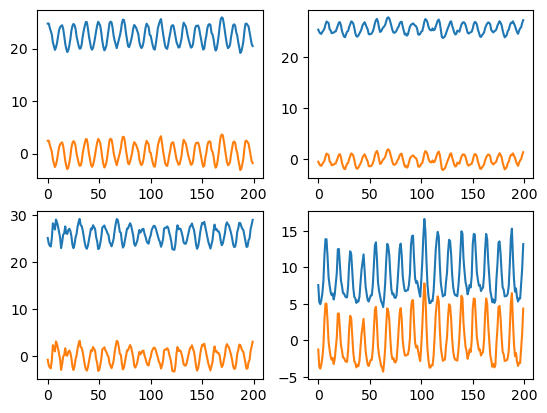

In [463]:
# Confirm detrend:
fig1, axes1 = plt.subplots(2, 2)
for ax, i in zip(axes1.flatten(), idx_detrendtest):
    ax.plot(test_detrend[:200,i])
    ax.plot(sst_detrend[:200,i])

**Extra code, playing around with other methods for linear detrending**

In [325]:
# sst_point = sstdata['sst'].values[:, 0, 0]
# x = np.arange(len(sst_point))
# results = linregress(x=x, y=sst_point, alternative='two-sided')
# results

In [326]:
#sst_point_fit = x*results.slope + results.intercept

In [327]:
# #sst_point_detrend = signal.detrend(sst_point, axis=0, type='linear', bp=0)
# sst_point_detrend = sst_point - sst_point_fit

In [328]:
# ...
#sst_detrend = signal.detrend(sst, axis=0, type='linear', bp=0)

### 2.2 Remove Seasonal Cycle

In [465]:
sst_detrend = sst_detrend.reshape((int(nt/12), 12, nlat, nlon), order='C')

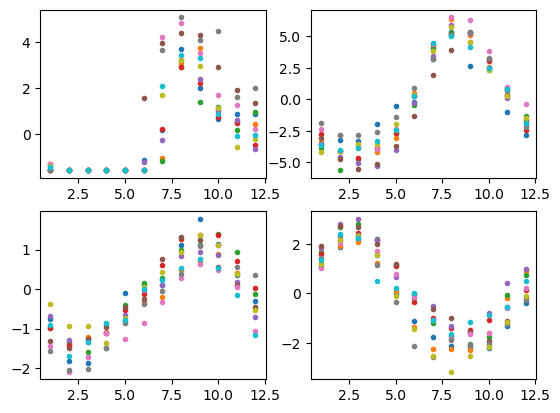

In [467]:
# Tets plot of seasonal cycle in several lat, lon locations:
xdummy =np.arange(1,13)

fig2, axes2 = plt.subplots(2, 2)

idx_seasonaltest = [(60, 150), (50, 100), (40, 90), (20, 160)] # lat,lon index pairs in sst_detrend
for ax, ii in zip(axes2.flatten(), idx_seasonaltest):
    for j in range(10): # Plot seasonal cycle for first 10 years
        ax.scatter(xdummy, sst_detrend[j, :, *ii], marker='.')

In [468]:
# Average seasonal cycle over all years:
sst_seasonal = sst_detrend.mean(axis=0)

In [469]:
sst_detrend = sst_detrend - sst_seasonal
sst_detrend.shape

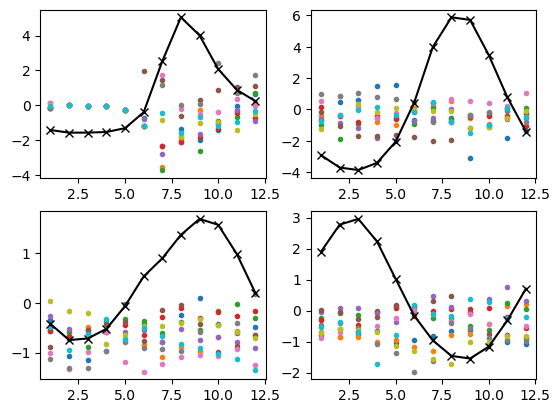

In [471]:
# Test plot of seasonal cycle and its subtraction at several gridpoint locations:
fig3, axes3 = plt.subplots(2, 2)

for ax, ii in zip(axes3.flatten(), idx_seasonaltest):
    ax.plot(xdummy, sst_seasonal[:, *ii], color='k', marker='x')
    for j in range(10): # Plot seasonal cycle for first 10 years
        ax.scatter(xdummy, sst_detrend[j, :, *ii], marker='.')

In [472]:
sst_detrend = sst_detrend.reshape(nt, nlat, nlon, order='C')

### *!!Start extra code temporarily (don't run as part of test yet)!!*

In [70]:
r = nt % 12

if r == 0:
    nt_temp = nt
else:
    nanpad = np.ones([12-r, nlat*nlon])*np.nan
    nt_temp = nt + (12-r)
    sst_detrend = np.append(sst_detrend, nanpad, axis=0)

In [286]:
#test = sst_detrend.transpose((1,0,2,3)).reshape(nt, nlat, nlon, order='F')

In [343]:
# #test = sst_detrend[:nt, ...]
# print(test.shape)

# plt.contourf(sstdata['lon'], sstdata['lat'], test[0, ...])
# plt.colorbar()

### *!!End extra code temporarily (don't run as part of test yet)!!*

In [473]:
sst_detrend_xa = xr.DataArray(
    data=sst_detrend,
    dims=['time', 'lat', 'lon'],
    coords=dict(
        lon=sstdata['lon'],
        lat=sstdata['lat'],
        time=sstdata['time']
    ),
    #attrs=dict(
    #    description="Ambient temperature.",
    #    units="degC",
    #),
)

In [475]:
sstvar = sst_detrend_xa.var(dim=['time'], skipna=True)

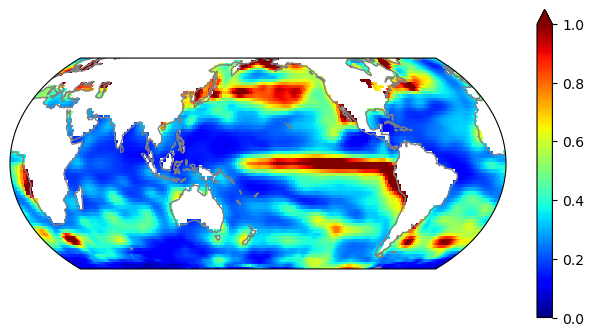

In [492]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'transform': PlateCarree()
}

figvar = plt.figure(figsize=(8, 4))
axvar = plt.axes(projection=proj)
sstvar.plot(vmin=0, vmax=1, cmap='jet', **kwargs)
axvar.coastlines(color='.5')

In [502]:
sst_detrend_xa = sst_detrend_xa.where(sstvar < 2, drop=False)

In [503]:
testvar = sst_detrend_xa.var(dim=['time'], skipna=True)

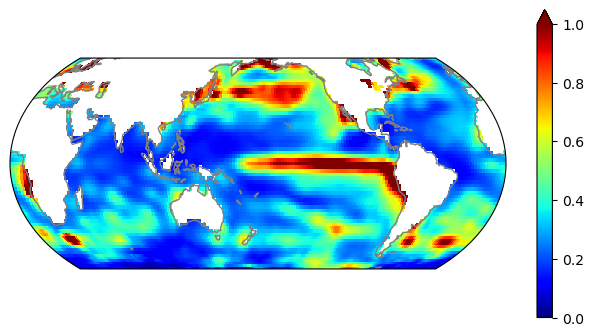

In [504]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'transform': PlateCarree()
}

figvar = plt.figure(figsize=(8, 4))
axvar = plt.axes(projection=proj)
testvar.plot(vmin=0, vmax=1, cmap='jet', **kwargs)
axvar.coastlines(color='.5')

### Try a second linear detrend? 

In [510]:
# # Save index locations of elements which are NAN, replace them with 0 for now:
# boolar_isnan = np.isnan(sst_detrend)
# sst_detrend[boolar_isnan] = 0

In [512]:
# # Perform linear fit and subtract from data:
# fitresults = np.polyfit(x, sst_detrend, 1, rcond=None, full=False, w=None, cov=False)
# print(sst_detrend.shape)
# print(fitresults[1].shape)

# lintrend = sst_detrend*fitresults[0] + fitresults[1] 
# print(lintrend.shape)
# sst_detrend = sst_detrend - lintrend

## 3. EOF decomp

In [505]:
import xeofs as xe

In [506]:
%%time

model = xe.models.EOF(n_modes=6, use_coslat=True)
model.fit(sst_detrend_xa, dim='time')

CPU times: user 1.17 s, sys: 110 ms, total: 1.28 s
Wall time: 372 ms


In [507]:
%%time

model.explained_variance_ratio().load()

CPU times: user 458 µs, sys: 13 µs, total: 471 µs
Wall time: 466 µs


<xarray.DataArray 'explained_variance_ratio' (mode: 6)>
array([0.19288002, 0.09804504, 0.03981679, 0.03164162, 0.02850735,
       0.02586461])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5 6
Attributes:
    model:        EOF analysis
    n_modes:      6
    standardize:  False
    use_coslat:   True
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-22 00:02:06

In [508]:
%%time

components = model.components().load()

CPU times: user 2.76 ms, sys: 0 ns, total: 2.76 ms
Wall time: 2.17 ms


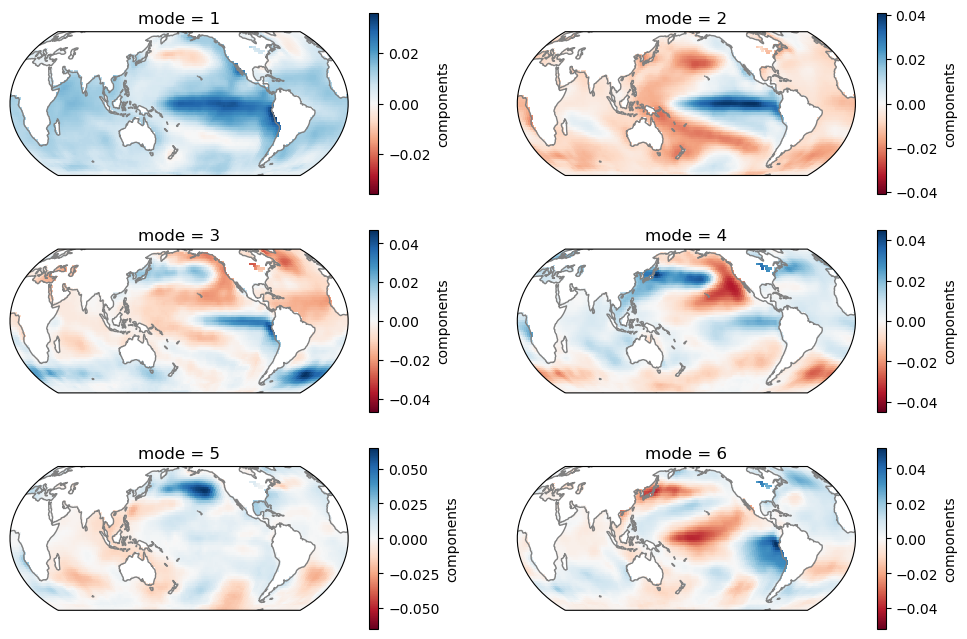

In [509]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'cmap' : 'RdBu', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, **kwargs)

In [450]:
%%time

scores = model.scores().load()

CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 1.43 ms


In [425]:
scores

<xarray.DataArray 'scores' (mode: 6, time: 1176)>
array([[-0.0641966 , -0.06483372, -0.0736565 , ...,  0.00745607,
         0.00171674, -0.00074331],
       [-0.01675178, -0.0102936 , -0.01509516, ..., -0.06687824,
        -0.06412206, -0.06463987],
       [ 0.01480325,  0.01995741,  0.0149308 , ..., -0.03101731,
        -0.03170816, -0.02152617],
       [ 0.01767917,  0.02697466,  0.0147919 , ...,  0.0577955 ,
         0.04058385,  0.02242055],
       [-0.03860105, -0.06078488, -0.06489645, ...,  0.00286958,
        -0.02267835, -0.03630306],
       [-0.01488701,  0.01359918,  0.02537073, ..., -0.01546   ,
        -0.00316985, -0.00244776]])
Coordinates:
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
  * mode     (mode) int64 1 2 3 4 5 6
Attributes:
    model:        EOF analysis
    n_modes:      6
    standardize:  False
    use_coslat:   True
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-21 23:08:10

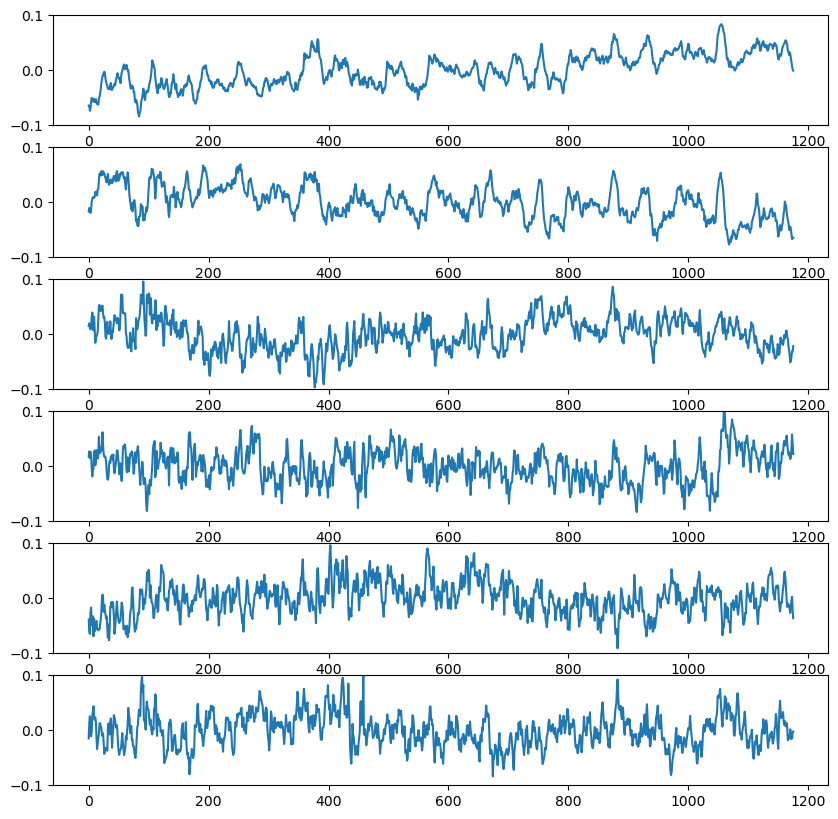

In [456]:
fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))
#plt.figure(figsize=(10,2))

for i, ax in zip(range(1, 7), axes5):
    ax.plot(scores.sel(mode=i).values)
    ax.set_ylim(-0.1, 0.1)

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

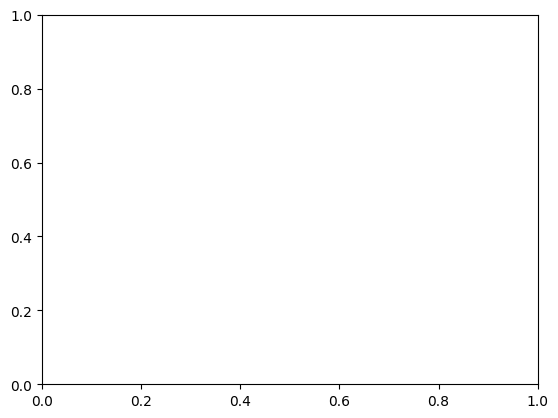

In [49]:
scores.sel(mode=1).plot()

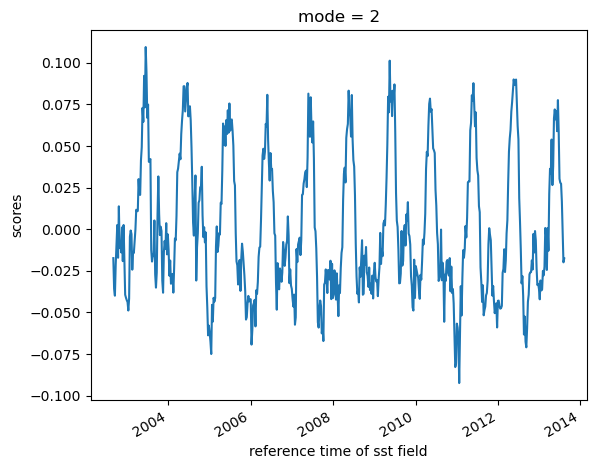

In [19]:
scores.sel(mode=2).plot()

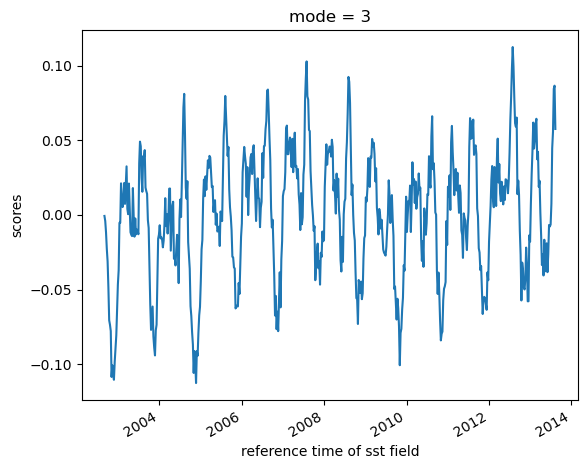

In [25]:
scores.sel(mode=3).plot()

## 4. EOF decomp with Dask

In [28]:
import coiled

In [29]:
cluster = coiled.Cluster(n_workers=10, region='us-west-2')

Output()

Package - coiled_local_working, Built wheel does not contain all python files!

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                        ╷                                                                         │
│   Package              │ Note                                                                    │
│ ╶──────────────────────┼───────────────────────────────────────────────────────────────────────╴ │
│   coiled_local_synced  │ Source wheel built from /scratch/synced                                 │
│   coiled_local_working │ Source wheel built from                                                 │
│                        │ /opt/coiled/rt/.path-deps/coiled_local_working-0.0.0-py3-none-any.whl   │
│                        ╵                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│                            ╷                                                        ╷            │
│   Package                  │ Error                                                  │ Risk       │
│ ╶──────────────────────────┼────────────────────────────────────────────────────────┼──────────╴ │
│   coiled_local_working     │ Built wheel does not contain all python files!         │ Warning    │
│                            ╵                                                        ╵            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [30]:
client = cluster.get_client()

In [31]:
client

<Client: 'tls://10.0.53.154:8786' processes=10 threads=40, memory=148.38 GiB>

In [40]:
client.shutdown()

In [11]:
from dask.distributed import Client, LocalCluster

In [12]:
client = Client()

In [13]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38015,Workers: 4
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:45299,Total threads: 1
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/39635/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:41045,


In [15]:
import xeofs as xe

In [19]:
sstdata['ssta'].mean().load()

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 120.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x7f6943b90d60>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    ref_count = self._ref_counter.decrement(self._key)
                ^^^^^^^^^^^^^^^^^
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [16]:
model = xe.models.EOF(n_modes=10)
model.fit(sstdata['ssta'], dim='time')

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 120.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x7f6943b90d60>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    ref_count = self._ref_counter.decrement(self._key)
                ^^^^^^^^^^^^^^^^^
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [35]:
evr = model.explained_variance_ratio()

In [36]:
evr

<xarray.DataArray 'explained_variance_ratio' (mode: 10)>
array([0.16010582, 0.08270313, 0.04050592, 0.02948766, 0.02791134,
       0.02421374, 0.02226816, 0.02088275, 0.01971089, 0.01908752],
      dtype=float32)
Coordinates:
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-14 20:54:42

In [38]:
sstdata['ssta']

<xarray.DataArray 'ssta' (time: 1176, lat: 89, lon: 180)>
dask.array<getitem, shape=(1176, 89, 180), dtype=float32, chunksize=(1, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1909-12-01 00:00:00 ... 2007-11-01 00:00:00
Attributes:
    long_name:  Extended reconstructed SST anomalies
    units:      degree_C
    valid_min:  -12.0
    valid_max:  12.0

## Appendix A: checking for nan's in the dataset

!This section reloads the data!

In [ ]:
sstdata = xr.open_mfdataset(fileobjs_good, chunks={})

In [ ]:
sstdata = sstdata.squeeze()
sst = sstdata['sst'].values

In [68]:
anan = []
for i in range(sst.shape[0]):
    anan.append(np.argwhere(np.isnan(sst)[i]).shape)

In [74]:
anan[0]

(3952, 2)

In [69]:
print(anan[0] == anan[1])

True


In [70]:
for a in anan:
    if a != anan[0]:
        print('flag!')